In [9]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw


In [5]:
!python trainSyn.py

Using TensorFlow backend.
W1121 18:22:33.908385 139992331380544 deprecation_wrapper.py:119] From trainSyn.py:25: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1121 18:22:33.908582 139992331380544 deprecation_wrapper.py:119] From trainSyn.py:27: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2020-11-21 18:22:33.908915: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-11-21 18:22:33.913112: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-11-21 18:22:34.008225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-21 18:22:34.008620: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x686f050 ex

In [28]:


# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/opt/app/github/Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib



In [29]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [30]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


In [210]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "syn0001"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1250

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    MASK_SIZE = [56,56]
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [219]:
class SynDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_syn(self, dataset_dir):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("leaf", 1, "leaf")

        
        rgb_dir = dataset_dir + '/rgb/'
        mask_dir = dataset_dir + '/np_mask/'
        
        
        image_ids = []
        for file in os.listdir(rgb_dir):
            if 'png' in file:
                image_ids.append(file)
        
        img_id = 0
        for image_id in image_ids:
            #print(image_ids[img_id])
            self.add_image(
            "leaf",
            image_id = img_id,
            path = dataset_dir + '/rgb/' + image_ids[img_id],
            )
            img_id+=1
        print('Loaded ' + str(img_id) + ' images')
            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        filename = (info['path'].split('/')[-1])
        #print('FILENAME', filename)
        mask = np.load('/opt/app/tobak/np_mask/'+filename +'.npy')
        mask = mask - 1
        #plt.imshow(mask)
        #plt.show()
        
        num_leaves = int(max(np.unique(mask)))+1
        good_mask = np.zeros((mask.shape[0],mask.shape[1],num_leaves))
        #print(num_leaves)
        for i in np.arange(num_leaves):
            good_mask[:,:,i] = mask==i
        return good_mask, np.ones([good_mask.shape[-1]], dtype=np.int32)


Loaded 50 images


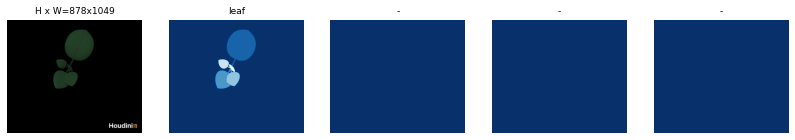

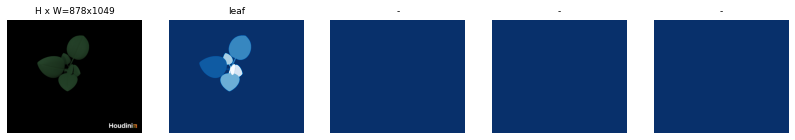

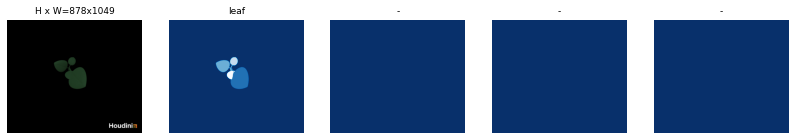

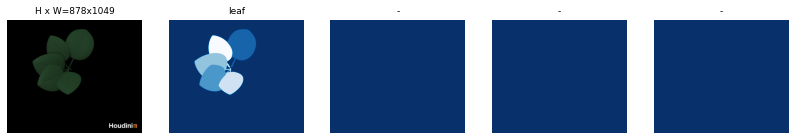

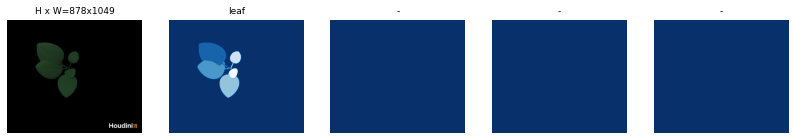

In [220]:

import matplotlib.pyplot as plt
dataset_train = SynDataset()
dataset_train.load_syn('/opt/app/tobak/')
dataset_train.prepare()

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [221]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [222]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


In [223]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [224]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_train, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /opt/app/github/Mask_RCNN/logs/syn000120201121T2243/mask_rcnn_syn0001_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may du

Epoch 1/4
1249/1250 [============================>.] - ETA: 0s - loss: 0.8295 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3202 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.2060

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1250/1250 [==============================] - 326s - loss: 0.8291 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3202 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.2058 - val_loss: 0.2883 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.0849 - val_mrcnn_class_loss: 0.0320 - val_mrcnn_bbox_loss: 0.0815 - val_mrcnn_mask_loss: 0.0867
Epoch 2/4
1250/1250 [==============================] - 205s - loss: 0.3206 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1204 - val_loss: 0.1507 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.0304 - val_mrcnn_class_loss: 0.0265 - val_mrcnn_bbox_loss: 0.0378 - val_mrcnn_mask_loss: 0.0547
Epoch 3/4
1250/1250 [==============================] - 207s - loss: 0.2231 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0979 - val_loss: 0.1501 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss

In [252]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.50

inference_config = InferenceConfig()

In [253]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [254]:


# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
model_path = '/opt/app/github/Mask_RCNN/logs/syn000120201121T2243/mask_rcnn_syn0001_0003.h5'
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Loading weights from  /opt/app/github/Mask_RCNN/logs/syn000120201121T2243/mask_rcnn_syn0001_0003.h5
Re-starting from epoch 3


Processing 1 images
image                    shape: (878, 1049, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1049.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


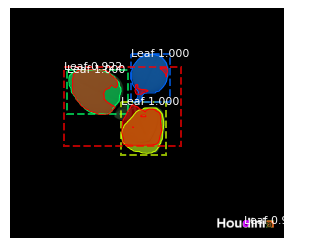

Processing 1 images
image                    shape: (878, 1049, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1049.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


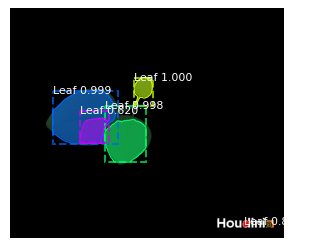

Processing 1 images
image                    shape: (878, 1049, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1049.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


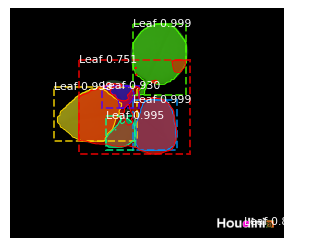

Processing 1 images
image                    shape: (878, 1049, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1049.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


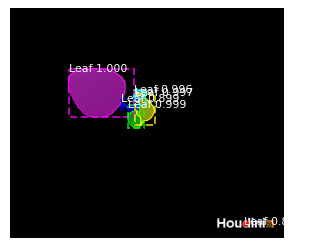

Processing 1 images
image                    shape: (878, 1049, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1049.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


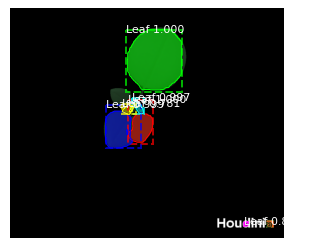

In [255]:
import cv2
dirrr = '/opt/app/tobak/rgb/'
import os
pngs = os.listdir(dirrr)[:5]

for i in pngs:
    if 'png' in i:
        img = cv2.imread(dirrr + i )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_arr = np.array(img)
        results = model.detect([img_arr], verbose=1)
        r = results[0]
        visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                    ['BG','Leaf'], r['scores'], figsize=(5,5))


Processing 1 images
image                    shape: (499, 700, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


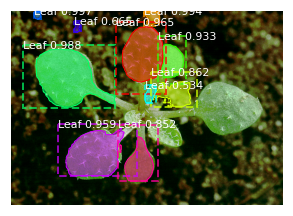

Processing 1 images
image                    shape: (503, 700, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


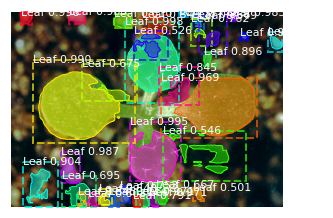

Processing 1 images
image                    shape: (866, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


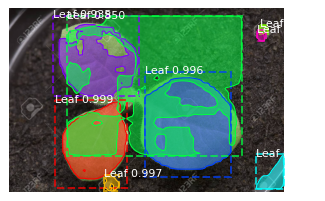

Processing 1 images
image                    shape: (291, 300, 3)         min:    0.00000  max:  220.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  105.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


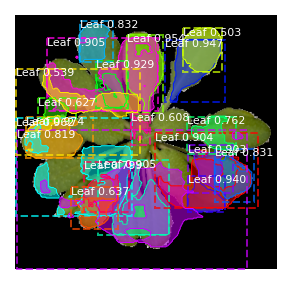

In [257]:
import cv2
dirrr = '/opt/app/Pictures/arabidopsis/'
import os
pngs = os.listdir(dirrr)

for i in pngs:
    if 'jpg' in i:
        img = cv2.imread(dirrr + i )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_arr = np.array(img)
        results = model.detect([img_arr], verbose=1)
        r = results[0]
        visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                    ['BG','Leaf'], r['scores'], figsize=(5,5))